In [1]:
import numpy as np 
import pandas as pd
from path import Path
from sklearn import metrics

In [2]:
#Set the random seed for reproducibility
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_random_seed(2)

/Users/namirsacic/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/namirsacic/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/namirsacic/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/namirsacic/anaconda3/lib/python3.7/site-packages/tensorflow/

In [3]:
def choose_csv(csv_name):
    #Read TSLA.csv contains open, high, low, close, Adj close, Volume of Apple stock with twitter polarity scores and twitter volumes
    file_path = Path(csv_name)
    df = pd.read_csv(file_path)
    #Drop null values
    df.dropna(inplace=True)
    
    return df

,Date,Open,High,Low,Close,Adj Close,Volume,ts_polarity,twitter_volume
917,2019-08-26,51.47,51.80,51.26,51.62,51.12,104174400,0.072340,888.0
918,2019-08-27,51.97,52.14,50.88,51.04,50.54,103493200,0.117541,962.0
919,2019-08-28,51.03,51.43,50.83,51.38,50.88,63755200,0.061477,895.0
920,2019-08-29,52.13,52.33,51.67,52.25,51.74,83962000,0.056460,1083.0
921,2019-08-30,52.54,52.61,51.80,52.19,51.67,84573600,0.106096,1005.0


In [4]:
def adjusted_df(df):
    #Dataframe with Adj close, ts_polarity, twitter_volume
    df = df[["Close", "compound"]]
    
    #pct change based on Adj close value
    df["Pct_change"] = df["Close"].pct_change()

    #Drop null values 
    df.dropna(inplace=True)
    df.head()
    
    return df

,Adj Close,ts_polarity,twitter_volume
0,24.44,0.070389,1133.0
1,23.83,0.133635,1430.0
2,23.36,0.072042,1949.0
3,22.38,0.074369,2289.0
4,22.50,0.051595,2235.0


Creating the Features X and Target y Data
The first step towards preparing the data was to create the input features X and the target vector y. We used the window_data() function to create these vectors.

This function chunks the data up with a rolling window of Xt - window to predict Xt.

The function returns two numpy arrays:

X: The input features vectors.

y: The target vector.

The function has the following parameters:

df: The original DataFrame with the time series data.

window: The window size in days of previous closing prices that will be used for the prediction.

feature_col_number: The column number from the original DataFrame where the features are located.

target_col_number: The column number from the original DataFrame where the target is located.

In [6]:
#Creation of vectors X and Y 
#X = input features / Y = target vector

def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number):
    #Create empty lists "X_close", "X_polarity",  "X_volume" and y
    X_close = []
    X_polarity = []
    X_volume = []
    y = []
    
    for i in range(len(df) - window):
        
        #Get close, ts_polarity, tw_vol and target in the loop
        close = df.iloc[i:(i + window), feature_col_number1]
        ts_polarity = df.iloc[i:(i + window), feature_col_number2]
        tw_vol = df.iloc[i:(i + window), feature_col_number3]
        target = df.iloc[(i + window), target_col_number]
        
        #Append values in the lists
        X_close.append(close)
        X_polarity.append(ts_polarity)
        X_volume.append(tw_vol)
        y.append(target)
        
    return np.hstack((X_close, X_polarity, X_volume)), np.array(y).reshape(-1, 1)

In [7]:
#Predict closing prices using a 3 day window of previous closing prices
window_size1 = 1
window_size3 = 3 
window_size5 = 5

#Column index 0 is the "Close" column
#Column index 1 is the "ts_polarity"
#Column index 2 is the "twitter_volume" column
feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
target_col_number = 0 
X, y = window_data(df, window_size, feature_col_number1, feature_col_number2, feature_col_number3, target_col_number)

#Predict closing prices using a 1 day window of previous closing prices
#Predict closing prices using a 5 day window of previous closing prices

In [5]:
def split_data(X, y):
    #Use 70% of the data for training and 30% for testing
    X_split = int(0.7 * len(X))
    y_split = int(0.7 * len(y))

    #Set X_train, X_test, y_train, t_test
    X_train = X[:X_split]
    X_test = X[X_split:]
    y_train = y[:y_split]
    y_test = y[y_split:]
    
    return X_train, X_test, y_train, y_test

Scaling Data with MinMaxScaler

We will use the MinMaxScaler from sklearn to scale all values between 0 and 1. Note that we scale both features and target sets.

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
def scale_data(X_train, y_train, X_test, y_test):
    #Use MinMaxScaler to scale data between 0 and 1
    x_train_scaler = MinMaxScaler()
    x_test_scaler = MinMaxScaler()
    y_train_scaler = MinMaxScaler()
    y_test_scaler = MinMaxScaler()

    #Fit the scaler for the Training data
    x_train_scaler.fit(X_train)
    y_train_scaler.fit(y_train)

    #Scale the training data
    X_train = x_train_scaler.transform(X_train)
    y_train = y_train_scaler.transform(y_train)

    #Fit the scaler for the Test data 
    x_test_scaler.fit(X_test)
    y_test_scaler.fit(y_test)

    #Scale the test data
    X_test = x_test_scaler.transform(X_test)
    y_test = y_test_scaler.transform(y_test)
    
    return X_train, y_train, X_test, y_test

Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a vertical vector, so that we need to reshape the X data in the form reshape((X_train.shape[0], X_train.shape[1], 1)).

Both sets, training, and testing are reshaped.

In [4]:
def reshape_features(X_train, X_test):
    #Reshape the features for the model
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, X_test

Build and Train the LSTM RNN

In this section, we designed a custom LSTM RNN and fit (train) it using the training data.

We have:

Defined the model architecture

Compiled the model

Fit the model to the training data

Importing the Keras Modules

The LSTM RNN model in Keras uses the Sequential model, the LSTM layer and a Dropout layer.

Dropout: Dropout is a regularization technique for reducing overfitting in neural networks. This type of layer applies the dropout technique to the input.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

Defining the LSTM RNN Model Structure

To create an LSTM RNN model, we added LSTM layers. The return_sequences parameter needs to set to True every time we add a new LSTM layer, excluding the final layer. The input_shape is the number of time steps and the number of indicators

After each LSTM layer, we add a Dropout layer to prevent overfitting. The parameter passed to the Dropout layer is the fraction of nodes that will be drop on each epoch, for this demo, we will use a dropout value of 0.2, it means that on each epoch we will randomly drop 20% of the units.

The number of units in each LSTM layers, is equal to three times the size of the time window, we are taking three previous closing prices to predict the next closing price.

In [13]:
#Build the LSTM model

def define_model(X_train):
    #Define the LSTM RNN model
    model = Sequential()

    number_units = 9
    dropout_fraction = 0.2

    #Layer 1
    model.add(LSTM(
        units=number_units,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1))
        )

    model.add(Dropout(dropout_fraction))

    #Layer 2
    #The return_sequences parameter needs to set to True every time we add a new LSTM layer, excluding the final layer
    model.add(LSTM(
        units=number_units, 
        return_sequences=True))
    model.add(Dropout(dropout_fraction))

    #Layer 3 
    model.add(LSTM(units=number_units))
    model.add(Dropout(dropout_fraction))

    #Output layer
    model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Compiling the LSTM RNN Model

We have compiled the model, using the adam optimizer, as loss function, we will use mean_square_error since the value we want to predict is continuous.

In [ ]:
#Compile the model
def compile_model(model):
    model.compile(optimizer="adam", loss="mean_squared_error")
    #Summarize model
    model.summary()
    
    return model

Training the Model

Once the model is defined, we train (fit) the model using 10 epochs. Since we are working with time-series data, it's important to set shuffle=False since it's necessary to keep the sequential order of the data.

We can experiment with the batch_size parameter; however, smaller batch size is recommended; we used batch_size=5.

In [16]:
def train_model(X_train, y_train):
    #Train the model
    model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=5, verbose=1)
    
    return model

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
642/642 [==============================] - 4s 6ms/sample - loss: 0.0142
Epoch 2/10
642/642 [==============================] - 2s 3ms/sample - loss: 0.0480
Epoch 3/10
642/642 [==============================] - 2s 3ms/sample - loss: 0.0428
Epoch 4/10
642/642 [==============================] - 2s 4ms/sample - loss: 0.0270
Epoch 5/10
642/642 [==============================] - 2s 3ms/sample - loss: 0.0194
Epoch 6/10
642/642 [==============================] - 2s 3ms/sample - loss: 0.0155
Epoch 7/10
642/642 [==============================] - 2s 3ms/sample - loss: 0.0113
Epoch 8/10
642/642 [==============================] - 2s 3ms/sample - loss: 0.0117
Epoch 9/10
642/642 [==============================] - 2s 3ms/sample - loss: 0.0111
Epoch 10/10
642/642 [==============================] - 2s 3ms/sample - loss: 0.0083


Model Performance

In this section, we will evaluate the model using the test data.

We will:

1. Evaluate the model using the X_test and y_test data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values.
4. Plot the Real vs predicted values as a line chart

In [17]:
def evaluate_model(X_test, y_test): 
    #Evaluation of model
    model.evaluate(X_test, y_test
    
    return model

276/276 [==============================] - 0s 1ms/sample - loss: 0.0136


0.013580113190455713

In [18]:
def make_pred(X_test):
    #Make predictions
    predicted = model.predict(X_test)
    
    return predicted

In [19]:
def calc_evaluation(y_test, predicted):
    #Evaluation of model
    print("Root Mean Squared Error: ", np.sqrt(metrics.mean_squared_error(y_test, predicted)))
    print("R-squared: ", metrics.r2_score(y_test, predicted))
    
    return root_mean_squared_error, r_squared

Root Mean Squared Error:  0.11653374302623919
R-squared:  0.7558099227306101


In [21]:
def show_pred(y_test_scaler)
    predicted_prices = y_test_scaler.inverse_transform(predicted)
    real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

    stocks = pd.DataFrame({
        "Real": real_prices.ravel(),
        "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
    stocks.head()
    
    return stocks

,Real,Predicted
646,46.39,50.760738
647,46.13,49.455578
648,46.22,50.114105
649,48.95,49.176933
650,50.38,49.984783


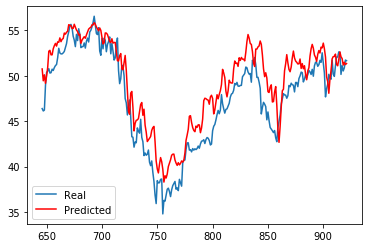

In [22]:
def plot_prediction(latest_df):
    #Plot the real vs predicted values as a line chart
    import matplotlib.pyplot as plt
    import pandas as pd

    # gca stands for 'get current axis'
    ax = plt.gca()

    stocks.plot(kind='line',y='Real',ax=ax)
    stocks.plot(kind='line',y='Predicted', color='red', ax=ax)

    plt.show()